## Búsqueda en espacio de estados

Adaptado de Russell & Norvig (2016), cap. 3.

### Objetivo

El estudio de búsqueda de soluciones para problemas abstractos es uno de los temas originales en la historia de la inteligencia artificial. Existen varios métodos para la búsqueda de soluciones, pero aquí nos enfocaremos en la creación de un árbol de estados y estudiaremos algunas estrategias para la búsqueda de una solución en este espacio.

### Secciones

Desarrollaremos la explicación de la siguiente manera:

1. Presentación de un problema de ejemplo.
* Implementación del problema en Python.
* Definición de árboles de búsqueda y su implementación en Python.
* Estrategias de búsqueda y su implementación en Python.

### Problema de ejemplo

El siguiente problema se conoce como las *ocho reinas*, el cual consiste en poner ocho reinas en un tablero de ajerdez de tal manera que ninguna pueda atacar a las demás. 

En el siguiente tablero hay siete reinas. ¿Es esta una situación admisible? ¿Cuál puede ser una solución al problema?

<img src="./imagenes/ocho_reinas.png" width="230">

¿Cómo definimos el *entorno*? Este puede representarse como una colección de estados, donde cada uno de ellos representa el tablero con cero o más reinas. Por su parte, las acciones del agente consisten en poner una reina en una casilla vacía del tablero (aunque no todas las acciones serán *aplicables* dado un estado del tablero).

**Ejercicio 1:**

De acuerdo con la formulación de entornos hecha durante la clase, ¿cuáles características considera usted que  tiene el *entorno* en este problema?

| Opción 1 | Opción 2 |
| :---: | :---: |
| $\checkmark$ Completamente observable | Parcialmente observable|
| $\checkmark$ Agente único | Multiagente |
| $\checkmark$ Determinista | Estocástico |
| Episódico    | $\checkmark$ secuencial  |
| $\checkmark$ Estático     | dinámico    |
| $\checkmark$ Discreto     | continuo    |
| $\checkmark$ Conocido     | desconocido |

----

La **definición formal** del problema se hace con base en la definición de las siguientes características:

* **Estado inicial**: Situación del entorno desde la cual el agente comienza a resolver el problema. En nuestro ejemplo, el estado inicial es el tablero vacío.

* **Posibles acciones**: Descripción de las posibles acciones del agente en el entorno, dado un estado `s`. Estas acciones se llaman las *acciones aplicables* en `s`. En nuestro problema, dado un estado con $k$ reinas ($k<8$), las acciones aplicables son poner una reina en una de las casillas vacías que no es atacada por ninguna de las otras reinas.

* **Función de transiciones**: Descripción del entorno que resulta de la ejecución de una de las acciones del agente. Junto con el estado inicial y las posibles acciones, la función de transiciones define el *espacio de estados* del problema. En nuestro ejemplo, la función toma un tablero con $k$ reinas ($k<8$) y devuelve un tablero con $k+1$ reinas.

* **Prueba de satisfacción del objetivo**: Es una prueba que permite determinar si un estado es un *estado objetivo* en el cual se resuelve el problema. Esta prueba puede contener una colección de estados objetivo (para chequear si el estado es uno de ellos) o puede estar dada en términos de una condición explícita que debe cumplir un estado. En nuestro ejemplo, la prueba debe verificar la condición de si un tablero dado contiene ocho reinas en el cual niguna puede atacar a la otra.

* **Función de costo**: Determina el costo numérico asociado a cada camino entre estados. En nuestro ejemplo, dicha función no es esencial, pero consideraremos que cada acción tiene el mismo costo, de tal manera que la función de costo es la cantidad de acciones realizadas (siempre devolverá el valor de 8 en cualquier solución). 


**Implementación del problema**

Implementaremos el problema de las ocho reinas mediante una clase en Python.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import numpy as np
from random import choice
import copy

%matplotlib inline

In [2]:
class ocho_reinas:
    
    def estado_inicial(self):
        return np.matrix([[0]*8]*8)
    
    def pintar_estado(self, estado):
        # Dibuja el tablero correspondiente al estado
        # Input: estado, que es una 8-lista de 8-listas
        fig, axes = plt.subplots()

        # Dibujo el tablero
        step = 1./8
        offset = 0.001
        tangulos = []

        # Borde del tablero
        tangulos.append(patches.Rectangle((0,0),0.998,0.998,\
                                          facecolor='cornsilk',\
                                         edgecolor='black',\
                                         linewidth=2))

        # Creo los cuadrados oscuros en el tablero
        for i in range(4):
            for j in range(4):
                tangulos.append(
                    patches.Rectangle(
                                      (2 * i * step, 2 * j * step), \
                                       step - offset, \
                                       step,\
                                       facecolor='lightslategrey')\
                                       )
                tangulos.append(
                    patches.Rectangle(
                                      (step + 2 * i * step, (2 * j + 1) * step), \
                                       step - offset, \
                                       step,\
                                       facecolor='lightslategrey')\
                                       )

        # Creo las líneas del tablero
        for j in range(8):
            locacion = j * step
            # Crea linea horizontal en el rectangulo
            tangulos.append(patches.Rectangle(*[(0, locacion), 1, 0.008],\
                    facecolor='black'))
            # Crea linea vertical en el rectangulo
            tangulos.append(patches.Rectangle(*[(locacion, 0), 0.008, 1],\
                    facecolor='black'))

        for t in tangulos:
            axes.add_patch(t)

        # Cargando imagen de la reina
        arr_img = plt.imread("./imagenes/reina.png", format='png')
        imagebox = OffsetImage(arr_img, zoom=0.048)
        imagebox.image.axes = axes
    
        offsetX = 0.065
        offsetY = 0.065
        for i in range(8):
            for j in range(8):
                if estado[j, i] == 1:
                    # print("Reina en (" + str(i) + ", " + str(j) + ")")
                    Y = 7 - j
                    X = i
                    # print("(" + str(X) + ", " + str(Y) + ")")
                    ab = AnnotationBbox(
                        imagebox, 
                        [(X*step) + offsetX, (Y*step) + offsetY], 
                        frameon=False)
                    axes.add_artist(ab)
        
        axes.axis('off')
        return axes
    
    def acciones_aplicables(self, estado):
        # Devuelve una lista de parejas que representan
        # las casillas vacías en las que es permitido
        # poner una reina adicional
        # Input: estado, que es una np.matrix(8x8)
        # Output: lista de indices (x,y)
        indices = [(x, y) for x in range(8) for y in range(8)]
        indices_bloqueados = []
        # Chequeamos primero que haya menos de ocho reinas
        if estado.sum() >= 8:
            return []
        else:
            # Bloqueamos índices por cada reina encontrada
            for x in range(8):
                for y in range(8):
                    if estado[y, x]==1:
                        #print("Reina encontrada en", x, y)
                        # Encuentra una reina
                        # Elimina la fila
                        #print("Bloqueando filas...")
                        indices_bloqueados += [(i, y) for i in range(8)]
                        # Elimina la columna
                        #print("Bloqueando columnas...")
                        indices_bloqueados += [(x, i) for i in range(8)]
                        # Elimina las diagonales \
                        # print("\nBloqueando diagonales...")
                        dif = np.abs(x-y)
                        offset_x = 0
                        offset_y = 0
                        for i in range(1, 8 - dif):
                            if (y + i) == 8:
                                offset_x = - (x + i)
                                offset_y = dif
                            if (x + i) == 8:
                                offset_x = dif
                                offset_y = - (y + i)
                            xB = (x + i + offset_x) % 8
                            yB = (y + i + offset_y) % 8
                            # print("(" + str(xB) + ", " + str(yB) + ")", end="")
                            indices_bloqueados.append((xB, yB))
                        # Elimina las transversales /
                        # print("\nBloqueando transversales...")
                        dif1 = np.abs((7-x)-y)
                        # print("\n Dif", dif1)
                        offset_x = 0
                        offset_y = 0
                        for i in range(1, 8 - dif1):
                            xB = (x + i + offset_x) % 8
                            yB = (y - i + offset_y) % 8
                            # print("(" + str(xB) + ", " + str(yB) + ")", end="")
                            indices_bloqueados.append((xB, yB))
                            if yB == 0:
                                offset_x = - (x + i + 1)
                                offset_y = x + i + 1
                            if xB == 7:
                                offset_x = y - (i + 1) - 7
                                offset_y = 8 - (y - i)

            return list(set(indices) - set(indices_bloqueados))

    def transicion(self, estado, indices):
        # Devuelve el tablero incluyendo una reina en el indice
        # Input: estado, que es una np.matrix(8x8)
        #        indice, de la forma (x,y)
        # Output: estado, que es una np.matrix(8x8)
        
        s = copy.deepcopy(estado)
        x = indices[0]
        y = indices[1]
        s[y, x] = 1
        return s
    
    def test_objetivo(self, estado):
        # Devuelve True/False dependiendo si el estado
        # resuelve el problema
        # Input: estado, que es una np.matrix(8x8)
        # Output: True/False
        # print("Determinando si hay exactamente ocho reinas...")
        num_reinas = estado.sum()
        if num_reinas != 8:
            # print("Numero incorrecto de reinas!")
            return False
        else:
            # print("Determinando si las reinas no se atacan...")
            # print("Buscando reina por fila...")
            filas = [i[0] for i in estado.sum(axis=1).tolist()]
            if any(i>1 for i in filas):
                # print("Dos reinas en la misma fila!")
                return False
            else:
                # print("Buscando reina por columna...")
                columnas = estado.sum(axis=0).tolist()[0]
                if any(j>1 for j in columnas):
                    # print("Dos reinas en la misma columna!")
                    return False
                else:
                    for x in range(8):
                        for y in range(8):
                            if estado[y, x]==1:
                                # print("Reina encontrada en (" + str(x) + ", " + str(y) + ")")
                                # print("Buscando otra reina en la misma diagonal...")
                                dif = np.abs(x-y)
                                offset_x = 0
                                offset_y = 0
                                for i in range(1, 8 - dif):
                                    if (y + i) == 8:
                                        offset_x = - (x + i)
                                        offset_y = dif
                                    if (x + i) == 8:
                                        offset_x = dif
                                        offset_y = - (y + i)
                                    xB = (x + i + offset_x) % 8
                                    yB = (y + i + offset_y) % 8
                                    if estado[yB, xB] == 1:
                                        #print("Dos reinas en la misma diagonal!")
                                        return False
            
                                # print("Buscando otra reina en la misma transversal...")
                                dif1 = np.abs((7-x)-y)
                                # print("\n Dif", dif1)
                                offset_x = 0
                                offset_y = 0
                                for i in range(1, 8 - dif1):
                                    xB = (x + i + offset_x) % 8
                                    yB = (y - i + offset_y) % 8
                                    # print("(" + str(xB) + ", " + str(yB) + ")", end="")
                                    if estado[yB, xB]==1:
                                        # print("Dos reinas en la misma transversal!")
                                        return False
                                    if yB == 0:
                                        offset_x = - (x + i + 1)
                                        offset_y = x + i + 1
                                    if xB == 7:
                                        offset_x = y - (i + 1) - 7
                                        offset_y = 8 - (y - i)
                                        
        return True 
    
    def costo(self, estado, accion):
        return 1

Este es el estado inicial:
Problema solucionado? False


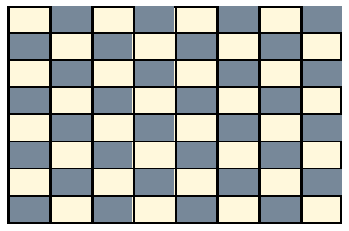

In [9]:
problema = ocho_reinas()
s = problema.estado_inicial()
print("Este es el estado inicial:")
problema.pintar_estado(s)
print("Problema solucionado?", problema.test_objetivo(s))

False

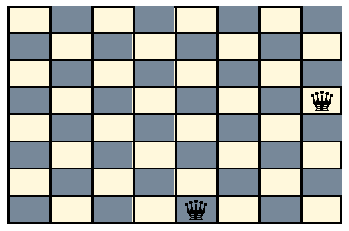

In [18]:
s1 = problema.transicion(s,problema.acciones_aplicables(s)[0]) #Elige la primera opcion de poner una reina en una casilla vacia
s1 = problema.transicion(s1,problema.acciones_aplicables(s1)[0])
problema.pintar_estado(s1)
problema.test_objetivo(s1)

### Árboles de búsqueda

Una vez definido el espacio de estados del problema, realizamos la búsqueda de una solución mediante un árbol de búsqueda. Recuerde que estamos considerando que una solución es una secuencia de acciones, que en nuestro caso resultará en una secuencia de posiciones en donde poner cada una de las ocho damas.

La intuición detrás de la construcción del árbol de búsqueda es suficientemente clara. Comenzamos con la raíz del árbol, la cual es el estado inicial del problema. Las aristas del árbol serán las acciones aplicables y los nodos los estados que se obtienen al realizar la correspondiente acción. Así pues, una solución será la rama que conduce desde la raíz hasta uno de los nodos que sea un estado objetivo del problema.

![](./imagenes/arbol.png)

El siguiente es el pseudocódigo del método de construcción del árbol, el cual explicaremos con un poco más de detalle a continuación:

<img src="./imagenes/tree_search.png" width="400px"/>

El método itera sobre la *frontera*, la cual consiste en los nodos que vamos a ir expandiendo para formar el árbol. Iremos analizando la frontera de manera iterativa hasta que se cumpla una de dos condiciones: la frontera es el conjunto vacío, en cuyo caso el problema no tiene solución; o el nodo sobre el cual se está trabajando es un estado objetivo, en cuyo caso la solución será la rama que va desde la raíz hasta el estado objetivo (observe que no está garantizado que este método siempre termine, debido a la posibilidad de caminos redundantes, ver ejercicio 4). 

En cualquier iteración, lo primero que debemos hacer es seleccionar un nodo `s` dentro de la frontera (sobre el método de selección volveremos más adelante; por el momento podemos asumir que se selecciona aleatoriamente). Retiramos a `s` de la frontera y revisamos si es un estado objetivo. Si sí, regresamos la solución; si no, debemos encontrar las acciones aplicables desde `s` y luego expandir la frontera con los estados que se obtienen a partir de las acciones aplicables.

Observe que no hemos dicho nada acerca de cómo seleccionar el nodo que se va a expandir. Esta elección es lo que constituirá la *estratégia de búsqueda*, sobre la cual volveremos más adelante.

**Implementación de los árboles**

In [21]:
class nodo:
    
    # Clase para crear los nodos
    
    def __init__(self, estado, madre, accion, costo):
        self.estado = estado
        self.madre = madre
        self.accion = accion
        self.costo = costo
        
def nodo_hijo(problema, madre, accion):
    
    # Función para crear un nuevo nodo
    # Input: problema, que es un objeto de clase ocho_reinas
    #        madre, que es un nodo,
    #        accion, que es una acción que da lugar al estado del nuevo nodo
    # Output: nodo

    return nodo(problema.transicion(madre.estado, accion),
                madre,
                accion,
                costo = madre.costo + problema.costo(madre.estado, accion)
               )

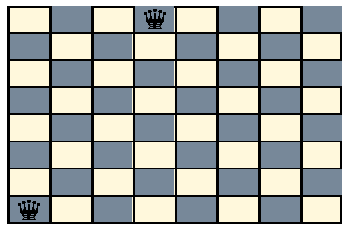

In [22]:
# Ejemplo de creación de un nodo a partir de la raíz
raiz = nodo(problema.estado_inicial(), None, None, 0)
acciones = problema.acciones_aplicables(raiz.estado)
a = choice(acciones)
n1 = nodo_hijo(problema, raiz, a)
acciones = problema.acciones_aplicables(n1.estado)
a = choice(acciones)
n2 = nodo_hijo(problema, n1, a)
problema.pintar_estado(n2.estado)

**Ejercicio 2:**

Implemente la función `solucion`, la cual toma un nodo `n` y devuelve la secuencia de acciones que va desde la raíz hasta `n`.

**Respuesta:**

Una posible implementación es la siguiente:

In [23]:
def solucion(n):
    
    # Devuelve la secuencia de estados que va desde la raíz
    # hasta el nodo n
    # Input: n, nodo
    # Output: l, lista de acciones
    
    acciones_invertidas = []
    m = copy.deepcopy(n)
    while m.madre != None:
        acciones_invertidas.append(m.accion)
        m = m.madre
    
    num_acciones = len(acciones_invertidas)
    acciones = []
    for i in range(1, num_acciones + 1):
        acciones.append(acciones_invertidas[num_acciones - i])
    
    return acciones

Otra posible implementación usando recursión es la siguiente:

In [24]:
def obtiene_acciones(n):
    if n.madre == None:
        return []
    else:
        return [n.accion] + obtiene_acciones(n.madre)
    
def solucion(n):
    acciones_invertidas = obtiene_acciones(n)
    N = len(acciones_invertidas)
    return [acciones_invertidas[N - i] for i in range(1, N + 1)]

In [25]:
solucion(n2)

[(0, 7), (3, 0)]

---

**Ejercicio 3:**

Use una lista como la variable *frontera* e implemente la función `tree_search` para resolver el problema de las ocho damas.

***Importante:*** Limíte la cantidad de hijos generados por un nodo a sólo 3.

**Respuesta:**

Una posible implementación es la siguiente:

In [63]:
def tree_search(problema):
    
    # Función de búsqueda mediante la construcción
    # del arbol de búsqueda de manera aleatoria
    
    raiz = nodo(problema.estado_inicial(), None, None, 0)
    
    frontera = [raiz]
    
    while len(frontera) > 0:
        # print("len(frontera)", len(frontera))
        n = choice(frontera) # Seleccionamos un nodo aleatorio
        # print("*****************")
        # print(n.estado)
        frontera.remove(n)
        if problema.test_objetivo(n.estado):
            return n
        else:
            acciones = problema.acciones_aplicables(n.estado)
            # Limitamos las acciones aplicables a aquellas
            # que están en la columna siguiente a la última dama
            #print("\nAcciones posibles:")
            #print([a for a in acciones])
            acciones_por_columna = [a for a in acciones if a[0]==n.estado.sum()]
            #print("\nAcciones posibles:")
            #print(acciones_por_columna)
            for a in acciones_por_columna[:3]: # Solo tomamos las 3 primeras acciones
                N = nodo_hijo(problema, n, a)
                # print("Nodo a incluir:")
                # print(N.estado)
                frontera.append(N)
    
    return None

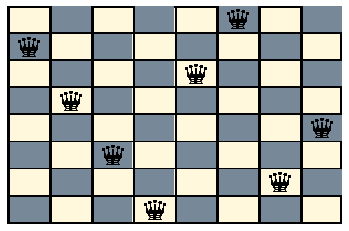

In [64]:
l = tree_search(problema)
if l: 
    problema.pintar_estado(l.estado)

---

**Ejercicio 4:**

Leer en el texto guía la discusión sobre caminos redundantes y el algoritmo `graph_search` (sección 3.3, págs. 76-77).

---

### Estrategias de búsqueda

Las estrategias que consideraremos aquí son algunas de las llamadas *estrategias ciegas* o *estrategias desinformadas*, las cuales consideran todas las acciones posibles en cualquier estado. A este tipo de estrategias se le opone el tipo de estrategias llamadas *estrategias informadas* o *heurísticas*, las cuales usan conocimiento específico del problema, más allá de su definición, para buscar soluciones de manera más eficiente.

Las dos estrategias ciegas que consideraremos son la *breadth-first* y *depth-first*. Observe que distintas estrategias tienen asociada una complejidad distinta, la cual también es importante examinar.

**Breadth-first search**

Lo que define a una estrategia de búsqueda de la forma *breadth-first* es que, después de expandir la raíz, se expanden primero todos sus hijos antes de expandir cualquier nieto, y así sucesivamente. En otras palabras, se expande la raíz, luego el primer nivel, luego el segundo, etc.

Implementar esta estrategia es fácil cuando se usa la variable `frontera` como una lista en python. En lugar de seleccionar un nodo aleatorio, se selecciona el primer nodo de la lista (`frontera[0]`). Observe que al expandir un nodo se agregan sus hijos a la lista mediante `append`, entonces los nodos de menor altura siempre van quedando al comienzo de la lista y los de mayor altura al final de esta.

El siguiente es el pseudo código que implementa esta estrategia, sobre el cual debemos hacer un par de aclaraciones:

<img src="./imagenes/breadth_first_search.png" width="450px"/>

La primera aclaración es que se ha modificado el lugar en el cual se determina si el nodo es un estado objetivo. Observe que se hace esta prueba justo después de crear el estado inicial, y luego también antes de incluir un nodo en la frontera. La razón de esta modificación es por eficiencia, toda vez que este procedimiento permite ahorrarse la generación de un nivel completo de nodos.

La segunda es que se está usando un conjunto llamado `explored`, el cual guarda la información de cuáles nodos ya han sido creados en el árbol. Esta es la manera de evitar caminos redundantes (ver ejercicio 4).

La presente estrategia de búsqueda garantiza que, si la solución existe, esta será encontrada en algún momento. Además, se encontrará la solución de menor altura en el árbol.

Las malas noticias es que su complejidad computacional es muy grande. Consideremos primero la siguiente notación:

* Sea $b$ la cantidad máxima de acciones posibles con respecto a cualquier estado. Observe que $b$ corresponde a la cantidad máxima de nodos que se incluirán en la frontera al expandir un nodo.

* Sea $d$ la altura del primer nodo que contenga un estado solución del problema.

Observe que en la primera iteración se generan $b$ nodos a partir de la raíz, luego $b$ nodos por cada uno de estos primeros $b$ nodos, y así, de tal manera que en la altura $d$ se generan $b^d$ nodos. Bajo la convención de medir el tiempo de ejecución del algoritmo solo en términos de la cantidad de nodos generados, se tiene que la complejidad de la estrategia `breadth-first` es $O(b + b^2 + b^3 + \ldots + b^d) = O(b^d)$.

Si medimos la cantidad de memoria requerida solo en términos de cuántos nodos debemos guardar en un instante dado, entonces debemos considerar que la `frontera` se expande con $b^n$ nodos en cada nivel. Por lo tanto, la complejidad con respecto a la memoria para obtener una solución con altura $d$ es también $O(b^d)$.

La siguiente tabla es muy ilustrativa del problema:

<img src="./imagenes/tabla_breadht_first.png" width="500px"/>

Observe que esta estimación determina que, para resolver el problema de las ocho reinas (altura 8) se requerirían 2 minutos y **103 gigabytes** de memoria (el estimado debe ser más alto, toda  vez que la tabla está pensada para un $b$ de 10, mientras que el problema de las ocho reinas tiene un $b$ promedio un poco más alto).

**Ejercicio 5:**

Implemente la función `breadth_first_search`.

***Importante:*** Limíte la cantidad de hijos generados por un nodo a solo 3!

**Respuesta:**

Una posible solución es la siguiente:

In [67]:
def breadth_first_search(problema):
    
    # Función de búsqueda mediante la construcción
    # del arbol en breadth-first
    
    raiz = nodo(problema.estado_inicial(), None, None, 0)
    
    if problema.test_objetivo(raiz.estado):
            return raiz
    else:
        frontera = [raiz]
        explored = []
    
    while len(frontera) > 0:
        # print("len(frontera)", len(frontera))
        n = frontera[0] # Seleccionamos el nodo con menor altura
        # print("*****************")
        # print(n.estado)
        frontera.remove(n)
        explored.append(n)
        acciones = problema.acciones_aplicables(n.estado)
        # Limitamos las acciones aplicables a aquellas
        # que están en la columna siguiente a la última dama
        acciones_por_columna = [a for a in acciones if a[0]==n.estado.sum()]
        # print("\nAcciones posibles:")
        # print(acciones_por_columna)
        for a in acciones_por_columna[:3]: # Solo tomamos las 3 primeras acciones
            N = nodo_hijo(problema, n, a)
            if problema.test_objetivo(N.estado):
                return N
            elif N not in explored:                
                # print("Nodo a incluir:")
                # print(N.estado)
                frontera.append(N)
    
    return None

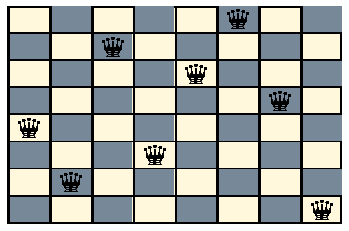

In [68]:
l = breadth_first_search(problema)
if l:
    problema.pintar_estado(l.estado)

---

**Depth-limited search**

A diferencia del anterior método de búsqueda, el *depth-first* siempre expande el nodo de mayor altura en la `frontera`. En el siguiente ejemplo, el método está recorriendo la rama de más a la izquierda antes de considerar nodos en otras ramas:

![](./imagenes/tree_depth_first_search.png)

A pesar de que podríamos implementar este método usando el código anterior - en donde el nodo a explorar no es el primero sino el último, de manera que se seleccione uno de los nodos de mayor altura - es más usual implementar *depth-first* de manera recursiva.

Antes de ver los detalles de esta implementación, observe que es muy importante evitar el problema de los caminos redundantes. Es posible usar el conjunto `explored`, como en la implementación del método de la sección anterior, pero lo más usual es considerar una búsqueda recursiva estableciendo de antemano una profundidad máxima de recursiones.

El pseudo código del algoritmo es el siguiente:

<img src="./imagenes/depth_limited_search.png" width="450px"/>

La desventaja principal de este método es que es posible explorar muchísimos nodos antes de encontrar una solución que está a muy poca altura en una rama que tarda en ser explorada. Por ejemplo, este sería el caso si en el árbol anterior la solución fuera el nodo `C`, toda vez que el algoritmo exploraría primero todos los nodos de las ramas izquierdas. Esto pone al método en una complejidad $O(b^m)$, donde $m$ es la máxima altura del árbol. 

No obstante, esta es una consideración sobre la peor situación posible, la cual debemos sopesar frente a la ventaja principal del método, a saber, un uso muchísimo más eficiente de la memoria. En efecto, sólo es necesario mantener en memoria a los hijos asociados a una sola rama del árbol, y es posible ir eliminando nodos tan pronto nos encontremos con un callejón sin salida (un nodo sin acciones aplicables). Esto pone la complejidad en memoria en el orden $O(bm)$; muchísmo menor que el $O(b^d)$ del método de la sección anterior.

**Ejercicio 6:**

Implemente la función `depth_limited_search`.

**Respuesta:**

Una posible solución es la siguiente:

In [17]:
def depth_limited_search(problema, limite):
    
    # Función de búsqueda que apela al algoritmo
    # recursive_DLS
    
    raiz = nodo(problema.estado_inicial(), None, None, 0)
    
    return recursive_DLS(raiz, problema, limite)

def recursive_DLS(n, problema, limite):
    
    # Función recursiva que recorre el árbol de
    # forma depth-limited.

    if problema.test_objetivo(n.estado):
            return n
    elif limite == 0:
        return "Cutoff"
    else:
        cutoff = False
        acciones = problema.acciones_aplicables(n.estado)
        for a in acciones:
            N = nodo_hijo(problema, n, a)
            resultado = recursive_DLS(N, problema, limite - 1)
            if resultado == "Cutoff":
                cutoff = True
            elif resultado != None:
                return resultado
        
        if cutoff:
            return "Cutoff"
        else:
            return None

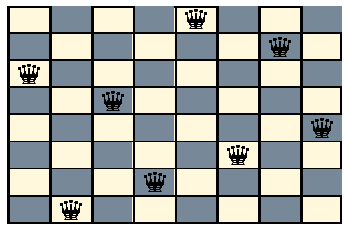

In [21]:
l = depth_limited_search(problema, 8)
if l:
    if l == "Cutoff":
        print(l)
    else:
        problema.pintar_estado(l.estado)

**Ejercicio 7:**

Lea la explicación sobre el *iterative deepening depth-first search*, en la sección 3.4.5 del texto guía, págs. 88-90.

---

### En este notebook usted aprendió

* Cómo definir formalmente un problema e implementarlo en python.

* En qué consiste un árbol de búsqueda y cómo implementarlo en python.

* Cómo realizar una búsqueda mediante los métodos *breadth-first* y *depth-limited* e implementarlos en python.